In [2]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)

import re
import json
import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt

from collections import defaultdict 

from tensorflow import keras as K
from tensorflow import one_hot

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import TimeDistributed

from tensorflow.keras.optimizers import Adam

GRU_LAYER = 1
LSTM_LAYER = 3
BILSTM_LAYER = 2

LAYER = LSTM_LAYER
EPOCHS = 30
MAX_LEN = 50
BATCH_SIZE = 16
HIDDEN_DIM = 100
VECTOR_DIM = 100
VALID_SPLIT = 0.2

In [3]:
def get_data(path):

    X = []
    Y = []

    data = json.load(open(path))

    for dict in data:

        x = dict['input']
        y = dict['output']

        n = len(x)

        for i in range(n):
            x[i] = re.sub('@[^ ]+','<username>',x[i])
            x[i] = re.sub('http://[^ ]+','<link>',x[i])
            x[i] = re.sub('#[^ ]+','<hashtag>',x[i])

            y[i] = re.sub('@[^ ]+','<username>',y[i])
            y[i] = re.sub('http://[^ ]+','<link>',y[i])
            y[i] = re.sub('#[^ ]+','<hashtag>',y[i])

        for _ in range(MAX_LEN-n):
            x.append('<pad>')
            y.append('<pad>')
        
        X.append(x)
        Y.append(y)

    return X, Y

In [4]:
def buildDict(data):

    wordToNum = {'<pad>':0}
    num = 1
    for sent in data:
        for word in sent:
            if word not in wordToNum.keys():
                wordToNum[word] = num
                num+= 1

    return wordToNum

In [5]:
def buildDictInv(wordToNum):

    numToWord = {}

    for key in wordToNum.keys():
        numToWord[wordToNum[key]] = key

    return numToWord

In [6]:
def tokenize(data,wordToNum):

    tokenizedData = []

    for sent in data:

        tokenizedSent = []
        for word in sent:
            tokenizedSent.append(wordToNum[word])

        tokenizedSent=np.array(tokenizedSent,dtype=float)
        tokenizedData.append(tokenizedSent)

    return np.array(tokenizedData)

In [7]:
def getModel(VOCAB_SIZE, layer_type):

    model = Sequential()

    model.add(Input(shape=(MAX_LEN,)))
    model.add(Embedding(VOCAB_SIZE, output_dim=VECTOR_DIM, input_length=MAX_LEN, trainable=True, mask_zero=True))

    if layer_type == GRU_LAYER:
      model.add(GRU(HIDDEN_DIM, return_sequences = True))

    elif layer_type == BILSTM_LAYER:
      model.add(Bidirectional(LSTM(HIDDEN_DIM, return_sequences = True)))
      
    else:
      model.add(LSTM(HIDDEN_DIM, return_sequences = True))
    
    model.add(TimeDistributed(Dense(VOCAB_SIZE)))
    model.add(Activation('softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
    
    print(model.summary())
    
    return model

In [8]:
def defineModel():

    raw, normalized = get_data('data/data.json')

    wordToNum = buildDict(raw + normalized)
    numToWord = buildDictInv(wordToNum)
    vocab_size = len(wordToNum)+1

    model       = getModel(vocab_size, LAYER)

    model.save('model.h5')
    pkl.dump(wordToNum, open('data/wordToNum.pkl', 'wb'))
    pkl.dump(numToWord, open('data/numToWord.pkl', 'wb'))

In [9]:
def plot(history):
    
    plt.plot(history.history['sparse_categorical_accuracy'])
    plt.plot(history.history['val_sparse_categorical_accuracy'])
    plt.title('model accuracy and loss')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.savefig(str(LAYER)+'_acc.png')
    plt.show()
    

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.savefig(str(LAYER)+'_loss.png')
    plt.show()
    

In [10]:
def train():

  model = K.models.load_model('model.h5')
  wordToNum = pkl.load(open('data/wordToNum.pkl', 'rb'))

  raw, normalized = get_data('data/data.json')
  print("Total Samples   : ", len(raw))

  raw = tokenize(raw, wordToNum)
  normalized = tokenize(normalized, wordToNum)

  x = raw
  y = normalized
  y = y.reshape(y.shape[0], y.shape[1], 1)

  history = model.fit(x, y, batch_size = BATCH_SIZE, epochs = EPOCHS, validation_split=VALID_SPLIT)

  model.save('model.h5')

  return history

In [11]:
defineModel()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 100)           2222900   
_________________________________________________________________
lstm (LSTM)                  (None, 50, 100)           80400     
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 22229)         2245129   
_________________________________________________________________
activation (Activation)      (None, 50, 22229)         0         
Total params: 4,548,429
Trainable params: 4,548,429
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
history = train()

Total Samples   :  4917
Epoch 1/30
246/246 [==============================] - 50s 61ms/step - loss: 2.2859 - sparse_categorical_accuracy: 0.0588 - val_loss: 2.0188 - val_sparse_categorical_accuracy: 0.0500
Epoch 2/30
246/246 [==============================] - 14s 55ms/step - loss: 1.8781 - sparse_categorical_accuracy: 0.0556 - val_loss: 1.9521 - val_sparse_categorical_accuracy: 0.0669
Epoch 3/30
246/246 [==============================] - 13s 55ms/step - loss: 1.7840 - sparse_categorical_accuracy: 0.1060 - val_loss: 1.9071 - val_sparse_categorical_accuracy: 0.1289
Epoch 4/30
246/246 [==============================] - 13s 54ms/step - loss: 1.6951 - sparse_categorical_accuracy: 0.1542 - val_loss: 1.8247 - val_sparse_categorical_accuracy: 0.1793
Epoch 5/30
246/246 [==============================] - 13s 53ms/step - loss: 1.5715 - sparse_categorical_accuracy: 0.2264 - val_loss: 1.7183 - val_sparse_categorical_accuracy: 0.2913
Epoch 6/30
246/246 [==============================] - 13s 54ms/ste

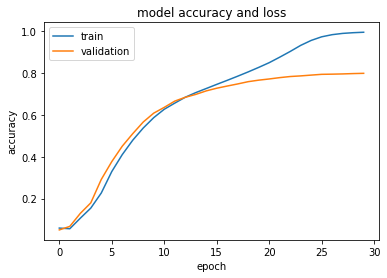

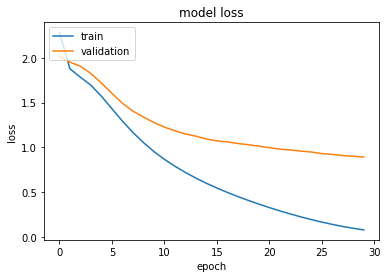

In [13]:
plot(history)